# Time-domain CSEM using Laplace-domain calculation with DLF

We use the analytical half-space solutions of Slob et al., 2010, PIERS, in the space-frequency, space-Laplace, and space-time domains and reproduce their Figure 4a.

In particular, we compare the analytical result in the time-domain with the numerical results in the time domain obtained through
- in Figure 1:
  - Analytical results in the space-frequency-domain followed by a sine-DLF;
  - Analytical results in the space-Laplace-domain followed by a Laplace-DLF;
  

- in Figure 2:
  - Analytical results in the wavenumber-frequency-domain followed by a Hankel-DLF and then a sine-DLF;
  - Analytical results in the wavenumber-Laplace-domain followed by a Hankel-DLF and then a Laplace-DLF.

#### References:
Slob, E., J. Hunziker, and W. A. Mulder, 2010, Green’s tensors for the diffusive electric field in a VTI half-space: PIER, 107, 1–20: DOI: [10.2528/PIER10052807](https://doi.org/10.2528/PIER10052807).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import empymod

In [2]:
# Style adjustments
%matplotlib notebook
plt.style.use('ggplot')
plt.rcParams['savefig.dpi'] = 300

## Model

Model of Figure 4a, Slob et al., 2010, PIERS. Halfspace with interface at z = 0 m, air above subsurface.

In [3]:
zsrc = 150      # Source horizontally at the origin at 150 m depth.
zrec = 200      # Receiver inline at 200 m depth.
offset = 2000   # Offset is 2 km.

# Collect model input for analytical solutions.
model = {
    'src': [0, 0, zsrc],
    'rec': [offset, 0, zrec],
    'res': 1,             # Horizontal resistivity 1 Ohm.m.
    'aniso': np.sqrt(5),  # Vertical resistivity 5 Ohm.m.
    'verb': 1
}

# Collect model input for numerical solutions.
modeln = model.copy()
modeln['depth'] = 0                     # Interface at 0 m.
modeln['res'] = [2e14, model['res']]    # Resistivity of air is 2e14 Ohm.m.
modeln['aniso'] = [1, model['aniso']]   # Anisotropy of air is 1.

times = np.logspace(-3, 3, 301)
signal = 0  # Impulse response

## Analytical time-domain result

In [4]:
out_ta = empymod.analytical(freqtime=times, solution='dhs', signal=signal, **model)

## Laplace-domain calculations

In [5]:
empymod.utils.set_minimum(min_freq=1e-40, min_time=1e-40)  # Necessary?

# Load Laplace-filter derived from diffusion function F(2).
#filt = empymod.filters.DigitalFilter('lap_201_f0', filter_coeff=['lap'])
#filt = empymod.filters.DigitalFilter('lap_201_f2', filter_coeff=['lap'])
#filt = empymod.filters.DigitalFilter('lap_201_f12', filter_coeff=['lap'])
#filt = empymod.filters.DigitalFilter('lap_201_empy', filter_coeff=['lap'])
#filt = empymod.filters.DigitalFilter('lap_201_empy2', filter_coeff=['lap'])
filt = empymod.filters.DigitalFilter('lap_201_empy3', filter_coeff=['lap'])
filt.fromfile()

pts_per_dec = -1  # Lagged Convolution DLF
kind = 'lap'

# Calculate required s-values {filt.base/times[:, None]}
req_s, _ = empymod.transform.get_spline_values(filt, times, pts_per_dec)
req_s = np.squeeze(req_s)

# Calculate corresponding values in the x-s-domain
req_la = empymod.analytical(freqtime=-req_s, solution='dhs', **model)  # Analytically
req_ln = empymod.dipole(freqtime=-req_s, **modeln)                     # Numerically

# Cast into Standard DLF format
if pts_per_dec == 0:
    req_la = req_la.reshape(times.size, -1)
    req_ln = req_ln.reshape(times.size, -1)

# Carry out DLF {np.dot(req_la, filt.lap)/times}
out_tl = empymod.transform.dlf(req_la, req_s, times, filt, pts_per_dec, kind=kind)   # x-s -> x-t result
out_tln = empymod.transform.dlf(req_ln, req_s, times, filt, pts_per_dec, kind=kind)  # k-s -> x-s -> x-t result

## Fourier-domain calculations

In [6]:
# Load Fourier Filter
filt = empymod.filters.key_201_CosSin_2012()

pts_per_dec = -1  # Lagged Convolution DLF
kind = 'sin'

# Calculate required frequencies {filt.base/times[:, None]}
req_f, _ = empymod.transform.get_spline_values(filt, 2*np.pi*times, pts_per_dec)
req_f = np.squeeze(req_f)

# Calculate corresponding analytical values in the x-f-domain
req_fa = empymod.analytical(freqtime=req_f, solution='dhs', **model)  # Analytically

# Cast into Standard DLF format
if pts_per_dec == 0:
    req_fa = req_fa.reshape(times.size, -1)

# Carry out DLF {np.dot(req_la, filt.lap)/times}
out_tf = empymod.transform.dlf(req_fa, req_f, times, filt, pts_per_dec, kind=kind)*2/np.pi  # x-f -> x-t result 
out_tfn = empymod.dipole(freqtime=times, signal=signal, **modeln)                    # k-f -> x-f -> x-t result

## Figure
Frequency- and Laplace-domain results calculated analytically.

<IPython.core.display.Javascript object>


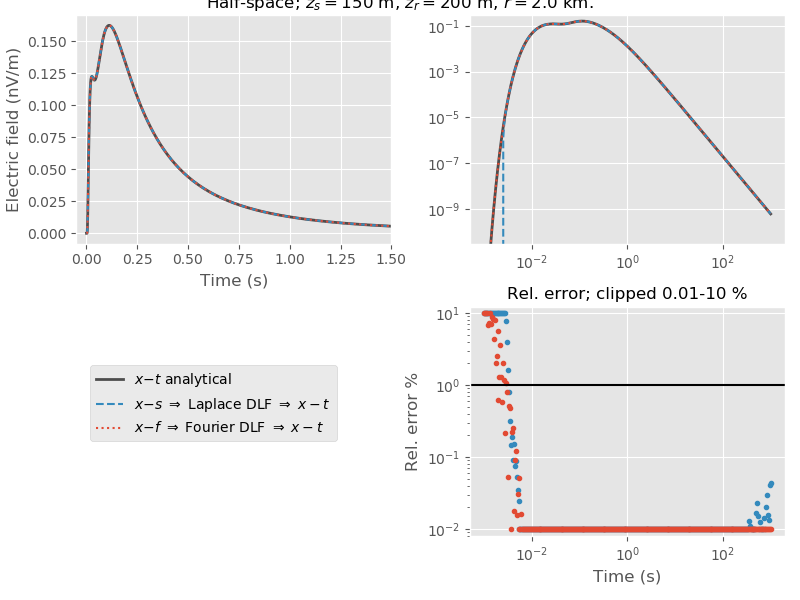

In [7]:
fig = plt.figure(figsize=(8, 6))
plt.suptitle(f"Half-space; $z_s = ${zsrc} m, $z_r = ${zrec} m, $r = ${offset/1000} km.", y=1.01)

ax1 = plt.subplot(221)
#plt.title('lin-lin')
plt.plot(times, out_ta*1e9, '.3', lw=2)
plt.plot(times, out_tl*1e9, 'C1--')
plt.plot(times, out_tf*1e9, 'C0:')
plt.xlim([-0.05, 1.5])
plt.ylabel('Electric field (nV/m)')
plt.xlabel('Time (s)')

ax2 = plt.subplot(222)
#plt.title('log-log')
plt.plot(times, out_ta*1e9, '.3', lw=2, label=r'$x\mathrm{-}t$ analytical')
plt.plot(times, out_tl*1e9, 'C1--', label=r'$x\mathrm{-}s$ $\Rightarrow$ Laplace DLF $\Rightarrow$ $x-t$')
plt.plot(times, out_tf*1e9, 'C0:', label=r'$x\mathrm{-}f$ $\Rightarrow$ Fourier DLF $\Rightarrow$ $x-t$')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e-3, 1e3])
plt.ylim([3e-11, 3e-1])

ax4 = plt.subplot(224, sharex=ax2)
plt.title('Rel. error; clipped 0.01-10 %', fontsize=12)

err = np.clip(100*abs((out_tl-out_ta)/out_ta), 0.01, 10)
errf = np.clip(100*abs((out_tf-out_ta)/out_ta), 0.01, 10)
#err = 100*abs((out_tl-out_ta)/out_ta)

plt.loglog(times, err, 'C1.')
plt.loglog(times, errf, 'C0.')
plt.axhline(1, c='k')
plt.xlabel('Time (s)')
plt.ylabel('Rel. error %')
plt.ylim([0.008, 12])

plt.tight_layout()

ax2.legend(bbox_to_anchor=(-0.4, -0.5))
plt.savefig('../figures/s2tempymod.pdf', bbox_inches='tight')
plt.show()

In [8]:
empymod.Report()

--------------------------------------------------------------------------------
  Date: Fri Nov 29 16:43:33 2019 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            1.17.3 : numpy
             1.3.1 : scipy
            1.10.2 : empymod
             2.7.0 : numexpr
             7.9.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------